In [2]:
!pip install pennylane

In [3]:
import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import sys

# Setting our constants
sys.path.append('..')

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [4]:
!wget https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_X.npy
!wget https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_y.npy

--2026-01-06 07:02:54--  https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_X.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32896 (32K) [application/octet-stream]
Saving to: ‘train_X.npy’

train_X.npy         100%[===================>]  32.12K  --.-KB/s    in 0.002s  

2026-01-06 07:02:54 (13.2 MB/s) - ‘train_X.npy’ saved [32896/32896]

--2026-01-06 07:02:54--  https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_y.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256 [

In [5]:
train_X = np.load("train_X.npy")
train_y = np.load("train_y.npy")

In [9]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# ==========================================
# 1. Inference (Model Prediction) - 기존 유지
# ==========================================
def get_predictions(model, inputs):
    """Run inference on inputs using the trained model."""
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)
    return predicted_labels.cpu().numpy()

def data_to_tensor(X, y):
    tensor_X = torch.tensor(X, dtype=torch.complex64)
    tensor_y = torch.tensor(y, dtype=torch.long)
    return tensor_X, tensor_y

t_train_X, t_train_y = data_to_tensor(train_X, train_y)
train_dataset = TensorDataset(t_train_X, t_train_y)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [42]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# [설정] 환경 설정 유지
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)
device = "cuda" if torch.cuda.is_available() else "cpu"

# ==========================================
# 1. 회로 수정 (Ring Entanglement 적용)
# ==========================================
def Quantum_classifier(params):
    wires = [i for i in range(n_qubits)]
    params = params.reshape(-1, 3, 8)

    # 마지막 레이어를 제외하고 반복 (Rot + CNOT)
    for layer in range(params.shape[0] - 1):
        # Rotation
        for i, wire in enumerate(wires):
            qml.Rot(params[layer, 0, i], params[layer, 1, i], params[layer, 2, i], wires=wire)

        # [수정 포인트 1] Linear -> Ring Entanglement
        # 기존: range(len(wires)-1) -> 0~1, 1~2 ... 끊김
        # 변경: range(len(wires)) + Modulo 연산 -> 7번이 0번과 연결됨 (정보 순환)
        for i in range(len(wires)):
            qml.CNOT(wires=[wires[i], wires[(i + 1) % len(wires)]])

    # 마지막 레이어 (Rot Only)
    for i, wire in enumerate(wires):
        qml.Rot(params[-1, 0, i], params[-1, 1, i], params[-1, 2, i], wires=wire)

@qml.qnode(dev, interface='torch')
def linear_2qubit_block(state, params):
    wires = [i for i in range(n_qubits)]
    qml.StatePrep(state, wires=wires)
    Quantum_classifier(params)
    return qml.probs(wires=[6, 7])

# ==========================================
# 2. 모델 및 학습 설정 (스케줄러 추가)
# ==========================================
class QNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 파라미터 수는 Baseline과 동일하게 유지 (120개)
        self.total_params = 5 * 3 * 8
        torch.manual_seed(42)
        # 초기화 유지
        self.params = nn.Parameter(torch.randn(self.total_params, requires_grad=True) * 0.01)

    def forward(self, x):
        preds = linear_2qubit_block(x, self.params)
        return preds

model = QNN()
model.to(device=device)

# Optimizer 유지
optimizer = optim.Adam(model.parameters(), lr=0.05)

epochs = 200

# [수정 포인트 2] 스케줄러 추가
# 학습이 진행될수록 학습률을 줄여서 Loss를 바닥까지 긁어냄
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.001)

print(f"--- Training QNN (Params: {model.total_params}) ---")

# Loss 함수 유지
def quantum_phase_loss(probs, labels):
    probs = probs + 1e-8 # Log 0 방지용 안전장치 추가
    label_one_hot = torch.nn.functional.one_hot(labels, num_classes=probs.shape[1])
    probs = probs / torch.sum(probs, dim=1, keepdim=True)
    loss = -torch.sum(label_one_hot * torch.log(probs), dim=1)
    return torch.mean(loss)

# 데이터 로더 (이전 컨텍스트의 데이터를 사용한다고 가정)
# train_loader가 없다면 이전 코드 블록을 실행해서 메모리에 올려두어야 합니다.
if 'train_loader' not in globals():
    # 임시: 데이터가 없으면 에러 방지를 위해 빈 리스트 처리 (실제 실행 시엔 데이터 로드 필수)
    print("주의: train_loader가 정의되지 않았습니다. 데이터를 로드하세요.")
    train_loader = []

# 학습 루프
for epoch in range(epochs):
    total_loss = 0
    correct = 0

    model.train()
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = quantum_phase_loss(predictions, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted_classes = torch.argmax(predictions, dim=1)
        correct += (predicted_classes == batch_y).sum().item()

    # [수정 포인트 2 관련] 스케줄러 업데이트
    scheduler.step()

    avg_loss = total_loss / len(train_loader) if len(train_loader) > 0 else 0
    avg_acc = correct / len(train_dataset) if len(train_dataset) > 0 else 0

    if (epoch + 1) % 20 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f} | LR: {current_lr:.5f}")

print("Training Finished.")

--- Training QNN (Params: 120) ---
Epoch 20 | Loss: 0.6010 | Train Acc: 0.9375 | LR: 0.04880
Epoch 40 | Loss: 0.5269 | Train Acc: 1.0000 | LR: 0.04532
Epoch 60 | Loss: 0.5152 | Train Acc: 0.9375 | LR: 0.03990
Epoch 80 | Loss: 0.5051 | Train Acc: 0.9375 | LR: 0.03307
Epoch 100 | Loss: 0.5046 | Train Acc: 0.9375 | LR: 0.02550
Epoch 120 | Loss: 0.4963 | Train Acc: 0.9375 | LR: 0.01793
Epoch 140 | Loss: 0.4963 | Train Acc: 0.9375 | LR: 0.01110
Epoch 160 | Loss: 0.4944 | Train Acc: 0.9375 | LR: 0.00568
Epoch 180 | Loss: 0.4939 | Train Acc: 0.9375 | LR: 0.00220
Epoch 200 | Loss: 0.4936 | Train Acc: 0.9375 | LR: 0.00100
Training Finished.


--- 🔍 Unfolding the Quantum Circuit (Ansatz Only) ---
잠시만 기다려주세요... 게이트가 많아 그리는 데 시간이 걸릴 수 있습니다.


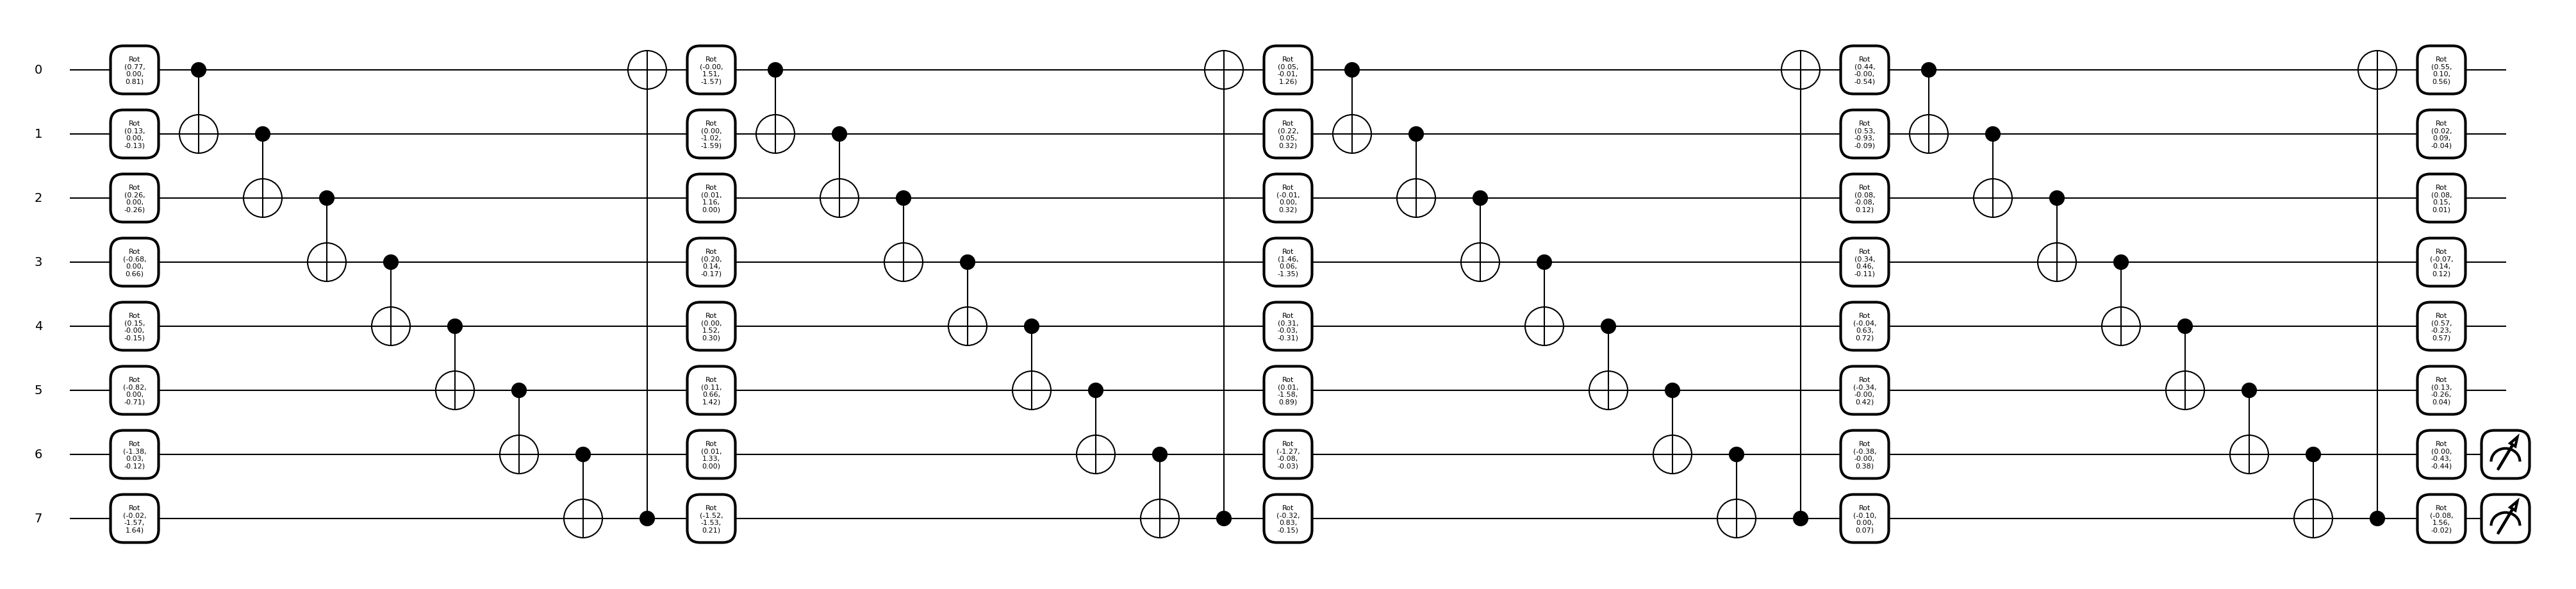

In [43]:
import matplotlib.pyplot as plt
import pennylane as qml

# =========================================================
# 1. 모델 구조만 보여주는 전용 함수 정의
# =========================================================
# 데이터 인코딩(StatePrep)을 빼고, 오직 '학습된 회로'만 그립니다.
# 이렇게 해야 거대한 StatePrep 블록에 방해받지 않고 내부를 볼 수 있습니다.
@qml.qnode(dev, interface="torch")
def visualize_ansatz_only(params):
    # 학습 때 사용한 함수 그대로 호출
    Quantum_classifier(params)
    return qml.probs(wires=[6, 7])

# =========================================================
# 2. 그리기 (level=2 옵션이 핵심)
# =========================================================
print("--- 🔍 Unfolding the Quantum Circuit (Ansatz Only) ---")
print("잠시만 기다려주세요... 게이트가 많아 그리는 데 시간이 걸릴 수 있습니다.")

# level=2: 모든 템플릿(StronglyEntanglingLayers)을 기본 게이트(Rot, CNOT) 단위까지 쪼갭니다.
# decimals=2: 파라미터 숫자를 소수점 2자리로 줄여서 그림이 깔끔해지게 합니다.
fig, ax = qml.draw_mpl(visualize_ansatz_only, level=2, decimals=2)(model.params)

# 그림 크기 최적화
plt.show()

In [44]:
import json

# 1. Specify measurement qubits (Baseline과 동일하게 6, 7번)
measurements = [6, 7]

# 2. Extract trained parameters (Best Model Params)
params = model.params.detach().cpu().numpy()

# 3. Define circuit for QASM conversion
# (학습 때 사용한 Quantum_classifier 함수를 그대로 호출)
@qml.qnode(dev, interface='torch')
def Classifier(params):
    Quantum_classifier(params)

# 4. Generate OpenQASM string
qasm_data = qml.to_openqasm(Classifier, measure_all=False)(params)

print(f"✅ Measurement Qubits: {measurements}")
print(f"✅ QASM Data Generated (Length: {len(qasm_data)} characters)")
print("--- QASM Preview (First 10 lines) ---")
print("\n".join(qasm_data.split('\n')[:10]))


with open("./baseline3.json", "w") as f:
    json.dump({
        "qasm": qasm_data,
        "measurements": measurements
    }, f)
print("✅ Submission file 'baseline3.json' created.")

✅ Measurement Qubits: [6, 7]
✅ QASM Data Generated (Length: 3082 characters)
--- QASM Preview (First 10 lines) ---
OPENQASM 2.0;
include "qelib1.inc";
qreg q[8];
creg c[8];
rz(0.7654122) q[0];
ry(0.0010377599) q[0];
rz(0.8061424) q[0];
rz(0.12894844) q[1];
ry(0.0018937424) q[1];
rz(-0.12988138) q[1];
✅ Submission file 'baseline3.json' created.


In [45]:
from google.colab import files
files.download('baseline3.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>